In [21]:
import json
import inspect
import re
import operator
from functools import partial
import itertools
import socket
import os
import sys
if re.match(r'^kaw130-\d+$', socket.gethostname()):
    os.environ['PROJ_HOME'] = os.path.expandvars('$HOME/dolphins-mc-su18')
    for d in ['src', 'lib', 'test', 'bin']:
        os.environ['PROJ_{}'.format(d.upper())] = os.path.expandvars('$PROJ_HOME/{}'.format(d))
    os.environ['PYTORCH_DATA_HOME'] = os.path.expandvars('$PROJ_HOME/.data')
    sys.path.extend(filter(os.path.isdir, map(os.path.expandvars, [
        '$PROJ_SRC',
        '$PROJ_LIB',
        '$PROJ_HOME/rt/lib/python3.6/site-packages',
    ])))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet101, vgg11, vgg13
import torchvision.transforms as trans
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from IPython.core.page import page
from PIL import Image
import cv2

import utils
import vmdata
import more_trans

%matplotlib inline

# Prepare dataset

In [14]:
root = vmdata.prepare_dataset_root(9, (8, 0, 0))
mean_std = vmdata.get_normalization_stats(root)
#mean_std = imagenet_mean_std
vdset = vmdata.VideoDataset(root, transform=trans.Compose([
    #trans.ToPILImage(),
    #trans.RandomCrop(224),
    #trans.ToTensor(),
    #trans.Normalize(*mean_std),
]))

def toimg(tensor):
    """Convert to HWC np.float64 image from (B)CHW tensor"""
    tensor = tensor.clone()
    if len(tensor.size()) == 4:
        assert tensor.size(0) == 1
        tensor = tensor.squeeze(0)
    tensor = more_trans.DeNormalize(*mean_std)(tensor)
    img = more_trans.chw2hwc(np.asarray(tensor))
    return img

# View the frames

In [15]:
plt.imsave('data/frame16.svg', toimg(vdset[16]))

In [19]:
vdset[16].shape[1:]

torch.Size([480, 704])

In [41]:
scale = 4
plt.imsave('data/frame16_ds{}x.svg'.format(scale),
           toimg(F.interpolate(vdset[16].unsqueeze(0), size=(480//scale, 704//scale))))

# Classify random-cropped patches using pretrained conv

This section uses a classifier (e.g. `resnet101`) pretrained on ImageNet without fine tuning to evaluate whether a randomly cropped image patch from the $480 \times 704$ video frames contains a dolphin. The pretrained network expects $224 \times 224$ sized image patch. If the cropped image is smaller than this size, it's upsampled using nearest neighbor.

To convert the 1000-class classification result to a scalar signifying the presence of a dolphin, all classes with $w$ occurrence where $w$ is a synonym to "dolphin" are selected, and the softmax score of these classes are summed together as the dolphin indicator. If it's greater than 0.5 (or some other threshold), then the image patch is said to contain a dolphin. The synonyms are recorded in `res/dolphin_synonyms.json`.

In [4]:
with open('res/imagenet_cid2label.json') as infile:
    imagenet_classnames = json.load(infile)
with open('res/dolphin_synonyms.json') as infile:
    _dolphin_synonyms = json.load(infile)
wordpat = re.compile(r'\b([a-zA-Z]+)\b')
_bow = map(wordpat.findall, imagenet_classnames)
keyword_indices = [i for i, x in enumerate(_bow) if len(set(x) - (set(x) - set(_dolphin_synonyms)))]
imagenet_mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
print('keyword_indices:', keyword_indices)
print()
print('keyword_classes:', *list(map(partial(operator.getitem, imagenet_classnames), keyword_indices)), sep='\n')

keyword_indices: [2, 3, 4, 147, 148]

keyword_classes:
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
tiger shark, Galeocerdo cuvieri
hammerhead, hammerhead shark
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus
killer whale, killer, orca, grampus, sea wolf, Orcinus orca


In [37]:
classifier = resnet101(pretrained=True).to('cpu')
_ = classifier.eval()

In [29]:
def dolphin_score(tensor):
    if len(tensor.size()) == 3:
        tensor = tensor.unsqueeze(0)
    if min(tensor.shape[2:4]) < 224:
        tensor = F.interpolate(tensor, size=(224, 224))
    assert tensor.size(0) == 1
    softmax = torch.nn.Softmax(dim=1)
    with torch.no_grad():
        scores = softmax(classifier(tensor))
    _, ind = scores.sort(dim=1)
    top5 = ind[0,-5:]
    top5names = tuple(map(partial(operator.getitem, imagenet_classnames), top5.tolist()))
    return top5names, tuple(scores[0,keyword_indices].tolist())

top5 predictions:
electric ray, crampfish, numbfish, torpedo
dugong, Dugong dugon
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
tiger shark, Galeocerdo cuvieri
hammerhead, hammerhead shark
---
dolphin scores:
0.03244301676750183
0.047767482697963715
0.849467396736145
0.0003135706065222621
0.005192409735172987
Total: 0.9351838765433058 | is_dolphin: True

CPU times: user 1.22 s, sys: 0 ns, total: 1.22 s
Wall time: 324 ms


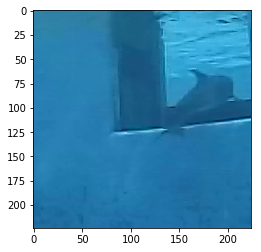

In [33]:
%%time
isd = False
while not isd:
    patch = vdset[600]
    _ = plt.imshow(toimg(patch))
    top5names, dolphin_scores = dolphin_score(patch)
    summed_dolphin_scores = sum(dolphin_scores)
    isd = (summed_dolphin_scores > 0.5)
    break
print('top5 predictions:', *top5names, sep='\n')
print('---')
print('dolphin scores:', *dolphin_scores, sep='\n')
print('Total:', summed_dolphin_scores, '|', 'is_dolphin:', (summed_dolphin_scores > 0.5))
print()

# Center-surround receptive field

In [102]:
class FoveatPooling(nn.Module):
    """
    Apply only to B&W frames.
    
    Input: a batch of B&W frames of shape (B, 1, H, W).
    Output: a batch of pooled feature maps of shape (B, 1, H', W')
    """
    def __init__(self, stride=1):
        super().__init__()
        self.conv = nn.Conv2d(1, 1, 3, stride=stride)
        _0, _1 = -1/16, 1/2
        self.conv.weight.requires_grad = False
        self.conv.weight.data = torch.tensor([[_0, _0, _0], [_0, _1, _0], [_0, _0, _0]]).view(1, 1, 3, 3)
        self.conv.bias.requires_grad = False
        self.conv.bias.data.zero_()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        cs = self.conv(x)
        con, coff = self.relu(cs), self.relu(-cs)
        return torch.cat((con, coff), dim=1)

pool = FoveatPooling(stride=2)

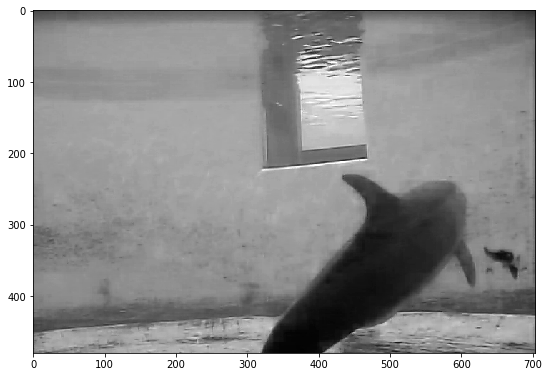

In [103]:
plt.figure(figsize=(9,8))
plt.imshow(vdset[10].max(axis=2), cmap='gray');

In [108]:
frame = torch.from_numpy((vdset[10].astype(np.float32)/255).max(axis=2)[np.newaxis, np.newaxis, ...])
frame = F.interpolate(frame, size=tuple(map(int, np.array(frame.shape[2:])/2)))
frame = pool(frame).sum(dim=1, keepdim=True)
frame = frame.numpy()
frame = (frame - np.min(frame)) / (np.max(frame) - np.min(frame))

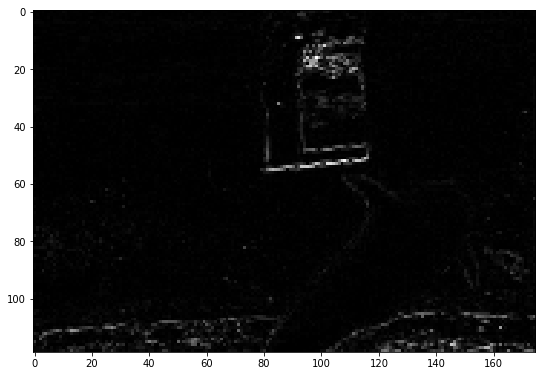

In [105]:
plt.figure(figsize=(9,8))
plt.imshow(frame[0,0], cmap='gray');

In [111]:
for i in range(len(vdset)):
    frame = vdset[i]
    frame = torch.from_numpy((vdset[10].astype(np.float32)/255).max(axis=2)[np.newaxis, np.newaxis, ...])
    frame = F.interpolate(frame, size=tuple(map(int, np.array(frame.shape[2:])/2)))
    frame = pool(frame).sum(dim=1, keepdim=True)
    frame = frame.numpy()
    frame = (frame - np.min(frame)) / (np.max(frame) - np.min(frame))
    frame = frame[0,0][...,np.newaxis]
    cv2.imshow('frame', frame)
    if cv2.waitKey(3000) & 0xFF == ord('q'):
        break

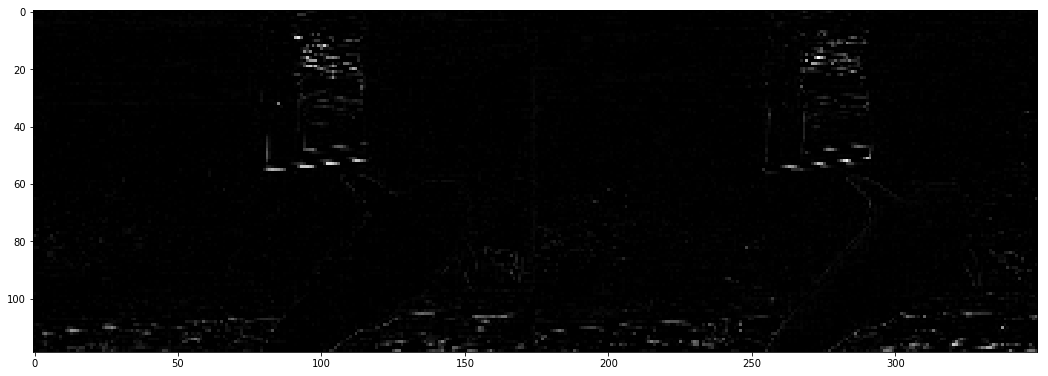

In [107]:
plt.figure(figsize=(18,8))
plt.imshow(np.concatenate((frame[0,0], frame[0,1]), axis=1), cmap='gray');

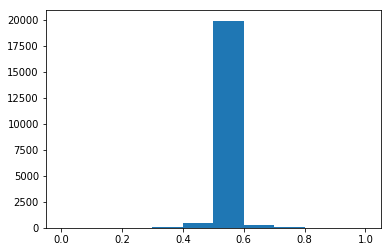

In [53]:
plt.hist(frame.reshape(-1));

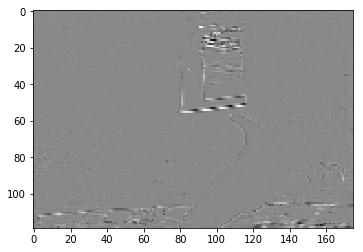

In [55]:
plt.imshow(frame, cmap='gray');

In [9]:
plt.imshow(toimg(vdset[0].max(dim=0, keepdim=True)[0]))

RuntimeError: The expanded size of the tensor (1) must match the existing size (3) at non-singleton dimension 0

# Interesting regions

In [10]:
classifier = vgg13(pretrained=True).to('cpu')
_ = classifier.eval()

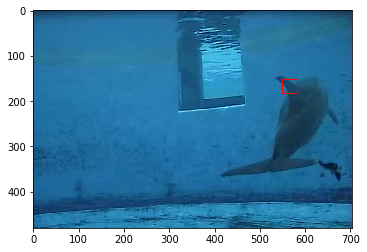

In [5]:
fig = plt.figure()
ax = plt.gca()
ax.imshow(toimg(vdset[16]))
rect = patches.Rectangle((550, 150), *(32,)*2, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

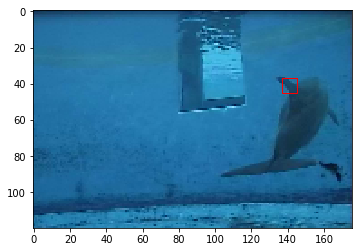

In [39]:
fig = plt.figure()
ax = plt.gca()
ax.imshow(toimg(F.interpolate(vdset[16].unsqueeze(0), size=(120, 176))))
rect = patches.Rectangle((275//2,75//2), *(16//2,)*2, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

In [11]:
features = classifier.features[:15]

In [7]:
np.prod(features(torch.rand(1,3,32,32)).size())

4096

## STN

In [12]:
central_radius = 32
periphr_radius = 512
H, W = vdset[0].shape[1:3]

In [13]:
def make_init_grid(radius, H, W):
    rows = np.linspace(-radius/(2*H), radius/(2*H), radius)
    cols = np.linspace(-radius/(2*W), radius/(2*W), radius)
    grid = np.meshgrid(rows, cols)
    grid = np.concatenate([x[...,np.newaxis] for x in grid], axis=2)
    return torch.from_numpy(grid).float()

In [14]:
central_initgrid = make_init_grid(central_radius, H, W)
periphr_initgrid = make_init_grid(periphr_radius, H, W)

In [296]:
frame = vdset[16]
x = 0.54
y = 0.48

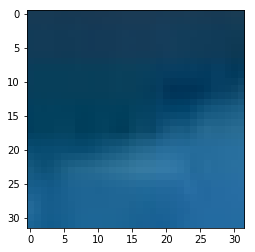

In [297]:
central_view = F.grid_sample(frame.unsqueeze(0), central_initgrid.unsqueeze(0) + torch.tensor([x,y]))
fig = plt.figure()
ax = plt.gca()
ax.imshow(toimg(central_view));

torch.Size([1, 3, 17, 17])


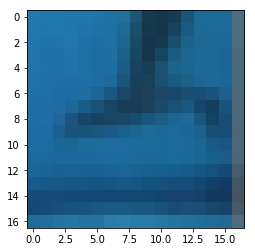

In [300]:
periphr_view = F.grid_sample(frame.unsqueeze(0), periphr_initgrid.unsqueeze(0) + torch.tensor([x,y]))
pool = torch.nn.AvgPool2d(56, 28)
pperiphr_view = pool(periphr_view)
fig = plt.figure()
ax = plt.gca()
ax.imshow(toimg(pperiphr_view));
print(pperiphr_view.size())

## Low-level feature extraction

In [301]:
features(pperiphr_view).size()

torch.Size([1, 256, 2, 2])

In [15]:
def cpfeatures(central_view, periphr_view):
    lc = features(central_view)
    lc = lc.view(lc.size(0), -1)
    lp = features(pool(periphr_view))
    lp = lp.view(lp.size(0), -1)
    latentview = torch.cat((lc, lp), dim=1)
    latentview = latentview.unsqueeze(0)
    return latentview

In [323]:
latentview = cpfeatures(central_view, periphr_view)

In [324]:
latentview.size()

torch.Size([1, 1, 5120])

## Gumbel softmax

[reference](https://gist.github.com/yzh119/fd2146d2aeb329d067568a493b20172f)

In [16]:
def sample_gumbel(logits, eps=1e-20):
    U = torch.rand_like(logits)
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits)
    return torch.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature=1.0):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [10]:
l = torch.rand(10, 4); l

tensor([[0.9181, 0.5405, 0.4662, 0.0124],
        [0.7818, 0.6102, 0.1374, 0.1339],
        [0.8898, 0.6957, 0.2782, 0.8928],
        [0.3827, 0.6480, 0.8011, 0.6667],
        [0.1228, 0.0650, 0.4253, 0.3047],
        [0.5726, 0.8960, 0.7753, 0.7705],
        [0.7361, 0.9589, 0.0038, 0.4968],
        [0.3536, 0.3167, 0.4505, 0.7453],
        [0.0631, 0.0783, 0.5085, 0.9599],
        [0.7766, 0.6302, 0.1434, 0.2303]])

In [27]:
gumbel_softmax(l, 1.0),torch.argmax(l, dim=-1)

(tensor([[0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.]]), tensor([0, 0, 3, 2, 2, 1, 1, 3, 3, 0]))

## Agents

In [17]:
frame = vdset[16]
x = 0.54
y = 0.48
lam = 0.01
T = 10

### A

In [14]:
lstm = nn.LSTM(input_size=5120, hidden_size=1024)
pool = torch.nn.AvgPool2d(56, 28)
affine_regr = nn.Linear(1024, 2)
affine_desc = nn.Linear(1024, 384)

In [336]:
offset = torch.tensor([x, y])
central_view = F.grid_sample(frame.unsqueeze(0), central_initgrid.unsqueeze(0) + offset)
periphr_view = F.grid_sample(frame.unsqueeze(0), periphr_initgrid.unsqueeze(0) + offset)
latentview = cpfeatures(central_view, periphr_view)
hidden = torch.zeros(1, 1, 1024), torch.zeros(1, 1, 1024)
for t in range(T):
    _, hidden = lstm(latentview, hidden)
    h, _ = hidden
    offset = torch.tanh(affine_regr(h[0])).view(-1)
    descri = gumbel_softmax(affine_desc(h[0])).view(-1)
    print(t, '({:2.4f}, {:2.4f})'.format(*offset.tolist()))
    
    central_view = F.grid_sample(frame.unsqueeze(0), central_initgrid.unsqueeze(0) + offset)
    periphr_view = F.grid_sample(frame.unsqueeze(0), periphr_initgrid.unsqueeze(0) + offset)
    latentview = cpfeatures(central_view, periphr_view)
    hidden = hidden[0].detach(), hidden[1].detach()

0 (0.1242, -0.1593)
1 (0.2116, 0.3697)
2 (-0.0067, 0.2864)
3 (0.0797, 0.2437)
4 (0.0605, 0.3399)
5 (0.1270, 0.2675)
6 (-0.0013, 0.0872)
7 (0.0403, -0.0784)
8 (0.0149, 0.2627)
9 (0.0648, 0.2244)


### B

In [31]:
dictionary = torch.randn(3*32*32, 384)

In [32]:
with torch.no_grad():
    globalview = features(frame.unsqueeze(0))
print(globalview.size())

torch.Size([1, 256, 60, 88])


## A+B

In [27]:
lstm = nn.LSTM(input_size=5120, hidden_size=1024)
affine_regr = nn.Linear(1024, 2)
affine_desc = nn.Linear(1024, 384)
dictionary = torch.randn(256*31*31, 384)
dictionary_bias = torch.zeros(1)
optimizer = torch.optim.Adam(itertools.chain(lstm.parameters(),
                                             affine_regr.parameters(),
                                             [dictionary, dictionary_bias]))

pool = torch.nn.AvgPool2d(56, 28)
features = vgg13(pretrained=True).to('cpu').features[:15].eval()
for param in features.parameters():
    param.requires_grad = False

The code below should be correct in terms of the computation graph. See the simplified computation graph here:

![cpgraph](data/simplified_cpgraph.jpg)

In [ ]:
losses = []

In [43]:
for i in range(10):
    globalview = features(frame.unsqueeze(0))
    offset = torch.tensor([x, y])
    central_view = F.grid_sample(frame.unsqueeze(0), central_initgrid.unsqueeze(0) + offset)
    periphr_view = F.grid_sample(frame.unsqueeze(0), periphr_initgrid.unsqueeze(0) + offset)
    latentview = cpfeatures(central_view, periphr_view)
    hidden = torch.zeros(1, 1, 1024), torch.zeros(1, 1, 1024)
    optimizer.zero_grad()
    total_loss = 0.0
    for t in range(T):
        _, hidden = lstm(latentview, hidden)
        descri = gumbel_softmax(affine_desc(hidden[0][0])).view(-1)
        kernel = torch.mv(dictionary, descri).view(1,256,31,31)
        sali = torch.sigmoid(F.conv2d(globalview, kernel, bias=dictionary_bias, stride=1, padding=15))
        target_sali = F.grid_sample(sali, central_initgrid.unsqueeze(0) + offset)  # bug here, shouldn't use central_initgrid
        loss = torch.sum(1.0 - target_sali) + lam * torch.sum(sali)
        loss.backward()
        total_loss += loss.item()

        hidden = hidden[0].detach(), hidden[1].detach()
        offset = torch.tanh(affine_regr(hidden[0][0])).view(-1)
        central_view = F.grid_sample(frame.unsqueeze(0), central_initgrid.unsqueeze(0) + offset)
        periphr_view = F.grid_sample(frame.unsqueeze(0), periphr_initgrid.unsqueeze(0) + offset)
        latentview = cpfeatures(central_view, periphr_view)
    optimizer.step()
    losses.append(total_loss / T)
    print(losses[-1])

511.73861198425294
563.3669509887695
706.6086624145507
675.9145965576172
585.4644744873046
407.15679092407225
637.4283828735352
546.6359649658203
457.14525985717773
462.9497261047363


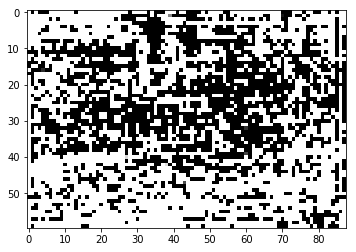

In [45]:
plt.imshow(sali[0,0].detach().numpy(), cmap='gray');

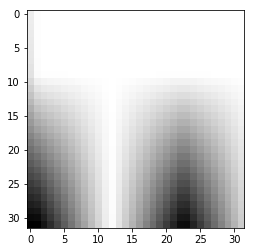

In [46]:
plt.imshow(target_sali[0,0].detach().numpy(), cmap='gray');

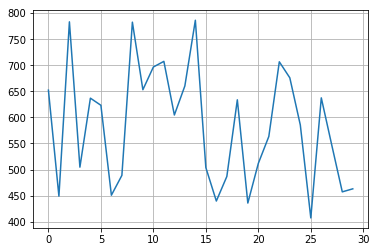

In [44]:
plt.plot(losses)
plt.grid()

# Remember to call this method

In [13]:
vdset.release_mmap()